# Prueba de simulación de horseshoe

Aquí simularemos un prior horseshoe, donde 5 parámetros serán significativamente distintos de 0, mientras que otros 45 rondarán valores cercanos a 0. Esto nos permitirá ver el uso de este prior en particular. 



In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt



D = 50  # Cantidad de predictores
D0 = 5  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 12345
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ModuleNotFoundError: No module named 'aesara'

Aquí lo que hicimos fue lo siguiente: 

* Definimos un intercepto
* Definimos un vector de 50 betas, de los cuales 5 toman valores de una normal(5,1) y luego se le asigna un "signo" al azar
* Se crea la matriz de diseño, con normales(0,1), y se fija sigma en 1
* Se calculan las medias determinísticas mu con el intercepto y la matriz de diseño por los betas
* Se simulan variables respuesta con normales(mu, sigma)

Luego se procede a la estimación bayesiana del modelo. Se propone como prior el horseshoe, para el cual se calculan los siguientes parámetros: 

$$\mu_i = \alpha + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$$

$$y_i \sim N(\mu_i, \sigma^2)$$

$$\alpha \sim N(0,1)$$

$$\beta_j \sim N(0,\lambda_j^2 \tau^2)$$

$$\lambda_j \sim C^+(0,1)$$

$$\tau \sim T^+(df=3)$$

$$\sigma^2 \sim N^+(0,1)$$

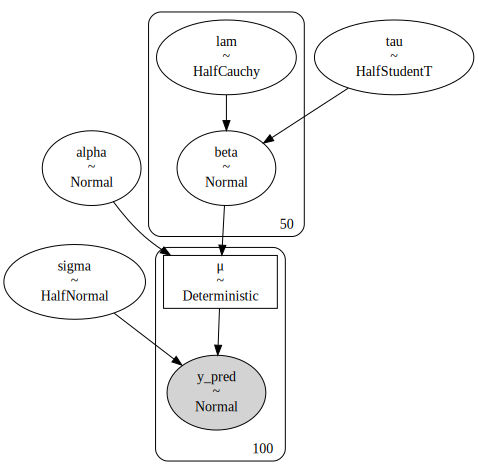

In [6]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('μ', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(modelo)

In [7]:
with modelo:
    idata = pm.sample(random_seed=123, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lam, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 584 seconds.
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
pd.set_option('display.max_rows', None)
az.summary(idata)

summary_df = az.summary(idata)
print(summary_df)

print(INTERCEPT)

             mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha      -1.644    0.102  -1.844   -1.463      0.002    0.001    2867.0   
beta[0]     5.002    0.106   4.812    5.205      0.002    0.002    2188.0   
beta[1]    -4.193    0.095  -4.369   -4.015      0.002    0.001    2108.0   
beta[2]    -3.678    0.099  -3.866   -3.498      0.002    0.001    2238.0   
beta[3]     5.598    0.099   5.412    5.783      0.002    0.002    1893.0   
beta[4]     5.498    0.092   5.335    5.677      0.002    0.001    2240.0   
beta[5]    -0.006    0.059  -0.129    0.113      0.002    0.002    1608.0   
beta[6]    -0.004    0.052  -0.125    0.087      0.001    0.001    1929.0   
beta[7]     0.027    0.065  -0.071    0.180      0.002    0.001    1677.0   
beta[8]    -0.018    0.057  -0.145    0.082      0.002    0.001    1514.0   
beta[9]     0.063    0.081  -0.039    0.240      0.002    0.001    1681.0   
beta[10]   -0.001    0.046  -0.096    0.091      0.001    0.001    1861.0   

Sampling: [alpha, beta, lam, sigma, tau, y_pred]


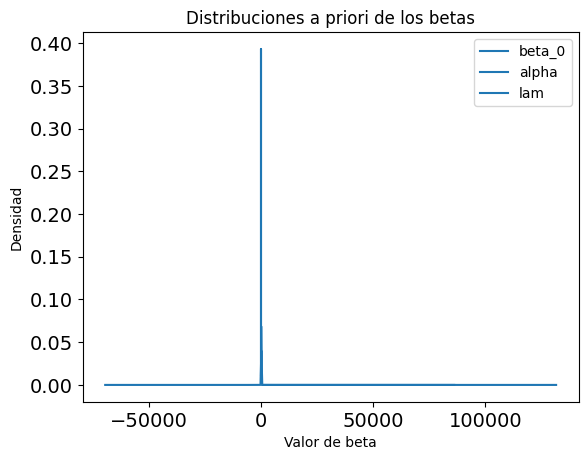

In [9]:
with modelo:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

az.plot_dist(prior_predictive.prior.beta, label='beta_0')
az.plot_dist(prior_predictive.prior.alpha, label='alpha')
az.plot_dist(prior_predictive.prior.lam, label='lam')

plt.xlabel('Valor de beta')
plt.ylabel('Densidad')
plt.title('Distribuciones a priori de los betas')
plt.legend()
plt.show()


## Ejemplo 2

Probemos usar distinta cantidad de valores para estos parámetros.

In [10]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 2398
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape

((100, 20), (100,), (100,))

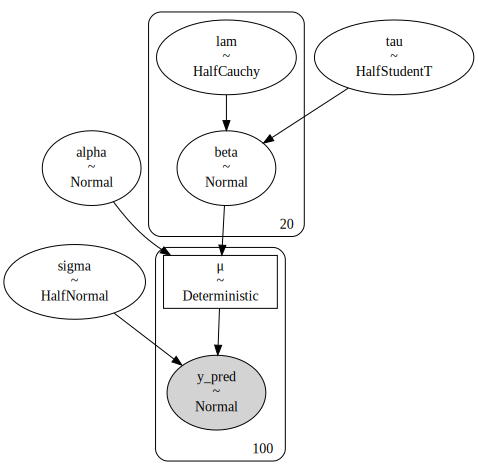

In [11]:
# Por ahora no cambiamos nada del modelo

with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('μ', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(modelo)

In [12]:
with modelo:
    idata = pm.sample(random_seed=1234, target_accept=0.95) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lam, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(idata)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.678,0.090,0.501,0.844,0.001,0.001,3805.0,3074.0,1.00
beta[0],6.673,0.095,6.496,6.850,0.002,0.001,3913.0,2378.0,1.00
beta[1],-5.455,0.105,-5.639,-5.246,0.002,0.002,2330.0,876.0,1.00
beta[2],5.789,0.100,5.609,5.971,0.002,0.001,2417.0,1928.0,1.00
beta[3],5.613,0.087,5.451,5.776,0.001,0.001,4882.0,2370.0,1.01
beta[4],4.967,0.075,4.825,5.109,0.001,0.001,3155.0,850.0,1.00
beta[5],5.096,0.091,4.917,5.267,0.002,0.002,1848.0,966.0,1.00
beta[6],5.632,0.097,5.449,5.818,0.002,0.001,3446.0,3002.0,1.00
beta[7],-5.403,0.079,-5.553,-5.254,0.001,0.001,4018.0,2454.0,1.00
beta[8],-4.486,0.095,-4.661,-4.304,0.002,0.001,3433.0,2276.0,1.00


En este caso también logró identificar bien a los parámetros significativos, sin embargo quedó uno de los valores 0 con el intervalo todo por debajo de 0, esto sería que lo está dando, aunque sea por poco, significativo. Ahora probaremos acercando un poco más los valores de los betas a 0, a ver qué tanto logran escaparse de este valor. Además aumentaremos un poco más la variabilidad de los datos. 

In [14]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 3648795
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(2, 1, size=D0)

N = 100

X = rng.normal(size=(N, D)) # A mayor desvío acá, menor desvío de las estimaciones (betas)

SIGMA = 1.5

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape

((100, 20), (100,), (100,))

In [15]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('μ', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=167823, target_accept=0.95) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lam, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

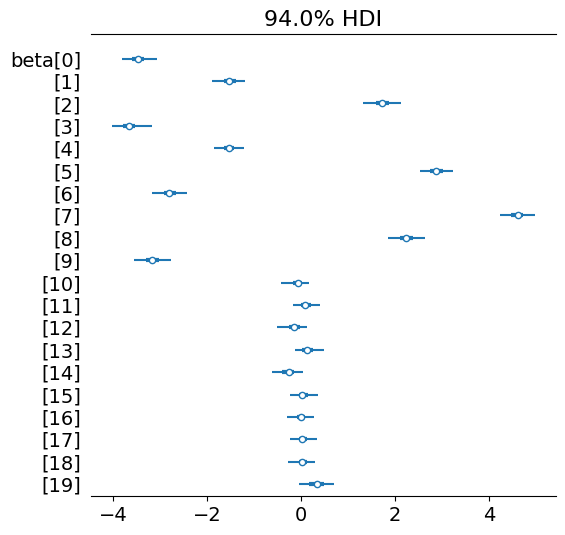

In [16]:
az.summary(idata)
# az.plot_trace(idata)
az.plot_forest(idata, var_names=['beta'], combined=True)



## Ejemplo 3

Vamos a cambiar algunos parámetros de las distribuciones de los hiperparámetros para ver como se comportan, bajo la misma configuración del modelo. 

In [17]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=10)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('μ', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=13234, target_accept=0.95) 

az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lam, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.243,0.189,-0.121,0.582,0.005,0.004,1388.0,1119.0,1.00
beta[0],-3.460,0.202,-3.847,-3.100,0.005,0.004,1466.0,2769.0,1.00
beta[1],-1.538,0.189,-1.885,-1.165,0.007,0.005,805.0,227.0,1.00
beta[2],1.723,0.222,1.226,2.090,0.009,0.006,758.0,210.0,1.01
beta[3],-3.672,0.216,-4.090,-3.271,0.006,0.004,1418.0,856.0,1.00
beta[4],-1.543,0.189,-1.873,-1.158,0.007,0.005,785.0,199.0,1.00
beta[5],2.865,0.194,2.479,3.200,0.004,0.003,2910.0,2922.0,1.00
beta[6],-2.789,0.199,-3.166,-2.423,0.004,0.003,2259.0,2757.0,1.00
beta[7],4.592,0.213,4.193,4.976,0.005,0.003,1847.0,308.0,1.00
beta[8],2.236,0.213,1.834,2.622,0.004,0.003,2772.0,2758.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

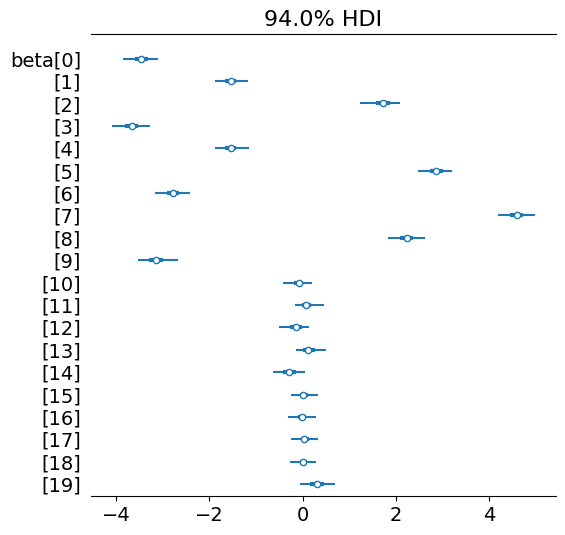

In [18]:
az.plot_forest(idata, var_names=['beta'], combined=True)


# Regularized horseshoe prior

Planteamos un modelo para utilizar el prior denominado como Regularized Horseshoe. Es similar al anterior solo

$$\mu_i = \alpha + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$$

$$y_i \sim N(\mu_i, \sigma^2)$$

$$\alpha \sim N(0,10)$$

$$\sigma^2 \sim N^+(0,2.5)$$

$$\beta_j \sim N(0,\tilde{\lambda}_j^2 \cdot \tau^2)$$

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}$$

(dado que se estima que hay efectivamente $D_0$ coeficientes distintos de 0)

$$\tau \sim T^+_2 ( \frac{D_0}{D-D_0} \cdot \frac{\sigma} {\sqrt{N}} )$$ 

$$\lambda_i \sim T^+_5(1)$$

$$c^2 \sim \textrm{GammaInv}(1, 1)$$



In [2]:
D = 50  # Cantidad de predictores
D0 = 5  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 12347565
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape


((100, 50), (100,), (100,))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=D0,
                         sharex=True, sharey=True,
                         figsize=(16, 6))

for i, (ax, coef) in enumerate(zip(axes[0], BETAS)):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} \\approx {coef:.2f}$");


zero_coef_ix = rng.choice(range(D0, D), replace=False, size=D0)
zero_coef_ix.sort()

for ax, i in zip(axes[1], zero_coef_ix):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} = 0$");
    
axes[0, 0].set_ylabel("$y$");
axes[1, 0].set_ylabel("$y$");

fig.tight_layout();

In [11]:
with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('μ', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=13234, target_accept=0.95) 

pd.set_option('display.max_rows', None)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, tau, lam, c2, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 547 seconds.
There were 353 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.234,0.101,-1.420,-1.035,0.002,0.001,2618.0,2200.0,1.00
beta[0],6.877,0.113,6.667,7.089,0.002,0.002,2167.0,2453.0,1.00
beta[1],-4.664,0.108,-4.870,-4.464,0.002,0.001,2717.0,2636.0,1.00
beta[2],5.534,0.108,5.326,5.732,0.002,0.002,2203.0,2689.0,1.00
beta[3],-6.285,0.099,-6.474,-6.101,0.002,0.001,2302.0,2353.0,1.00
beta[4],-4.185,0.094,-4.362,-4.014,0.002,0.001,2526.0,2825.0,1.00
beta[5],-0.018,0.051,-0.137,0.063,0.001,0.001,1578.0,1244.0,1.01
beta[6],0.007,0.049,-0.093,0.104,0.001,0.001,1586.0,1470.0,1.00
beta[7],0.004,0.047,-0.097,0.099,0.001,0.001,1395.0,1014.0,1.00
beta[8],-0.118,0.101,-0.298,0.030,0.003,0.002,1169.0,2496.0,1.00


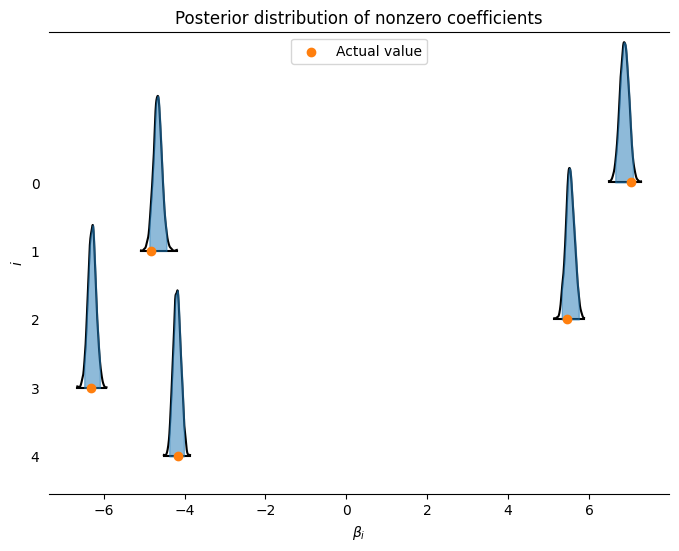

In [10]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D0)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D0][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D0)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");